In [2]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Reading csv file and loading the dataset
df=pd.read_csv('images.csv')
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


# Data Exploration

In [5]:
df.shape

(5403, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5403 non-null   object
 1   sender_id  5403 non-null   int64 
 2   label      5403 non-null   object
 3   kids       5403 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 132.0+ KB


In [7]:
#Checking for missing values
df.isnull().sum()

image        0
sender_id    0
label        0
kids         0
dtype: int64

In [8]:
df['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

In [11]:
df['label']=df['label'].replace('Not sure','not_sure')
df['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
not_sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

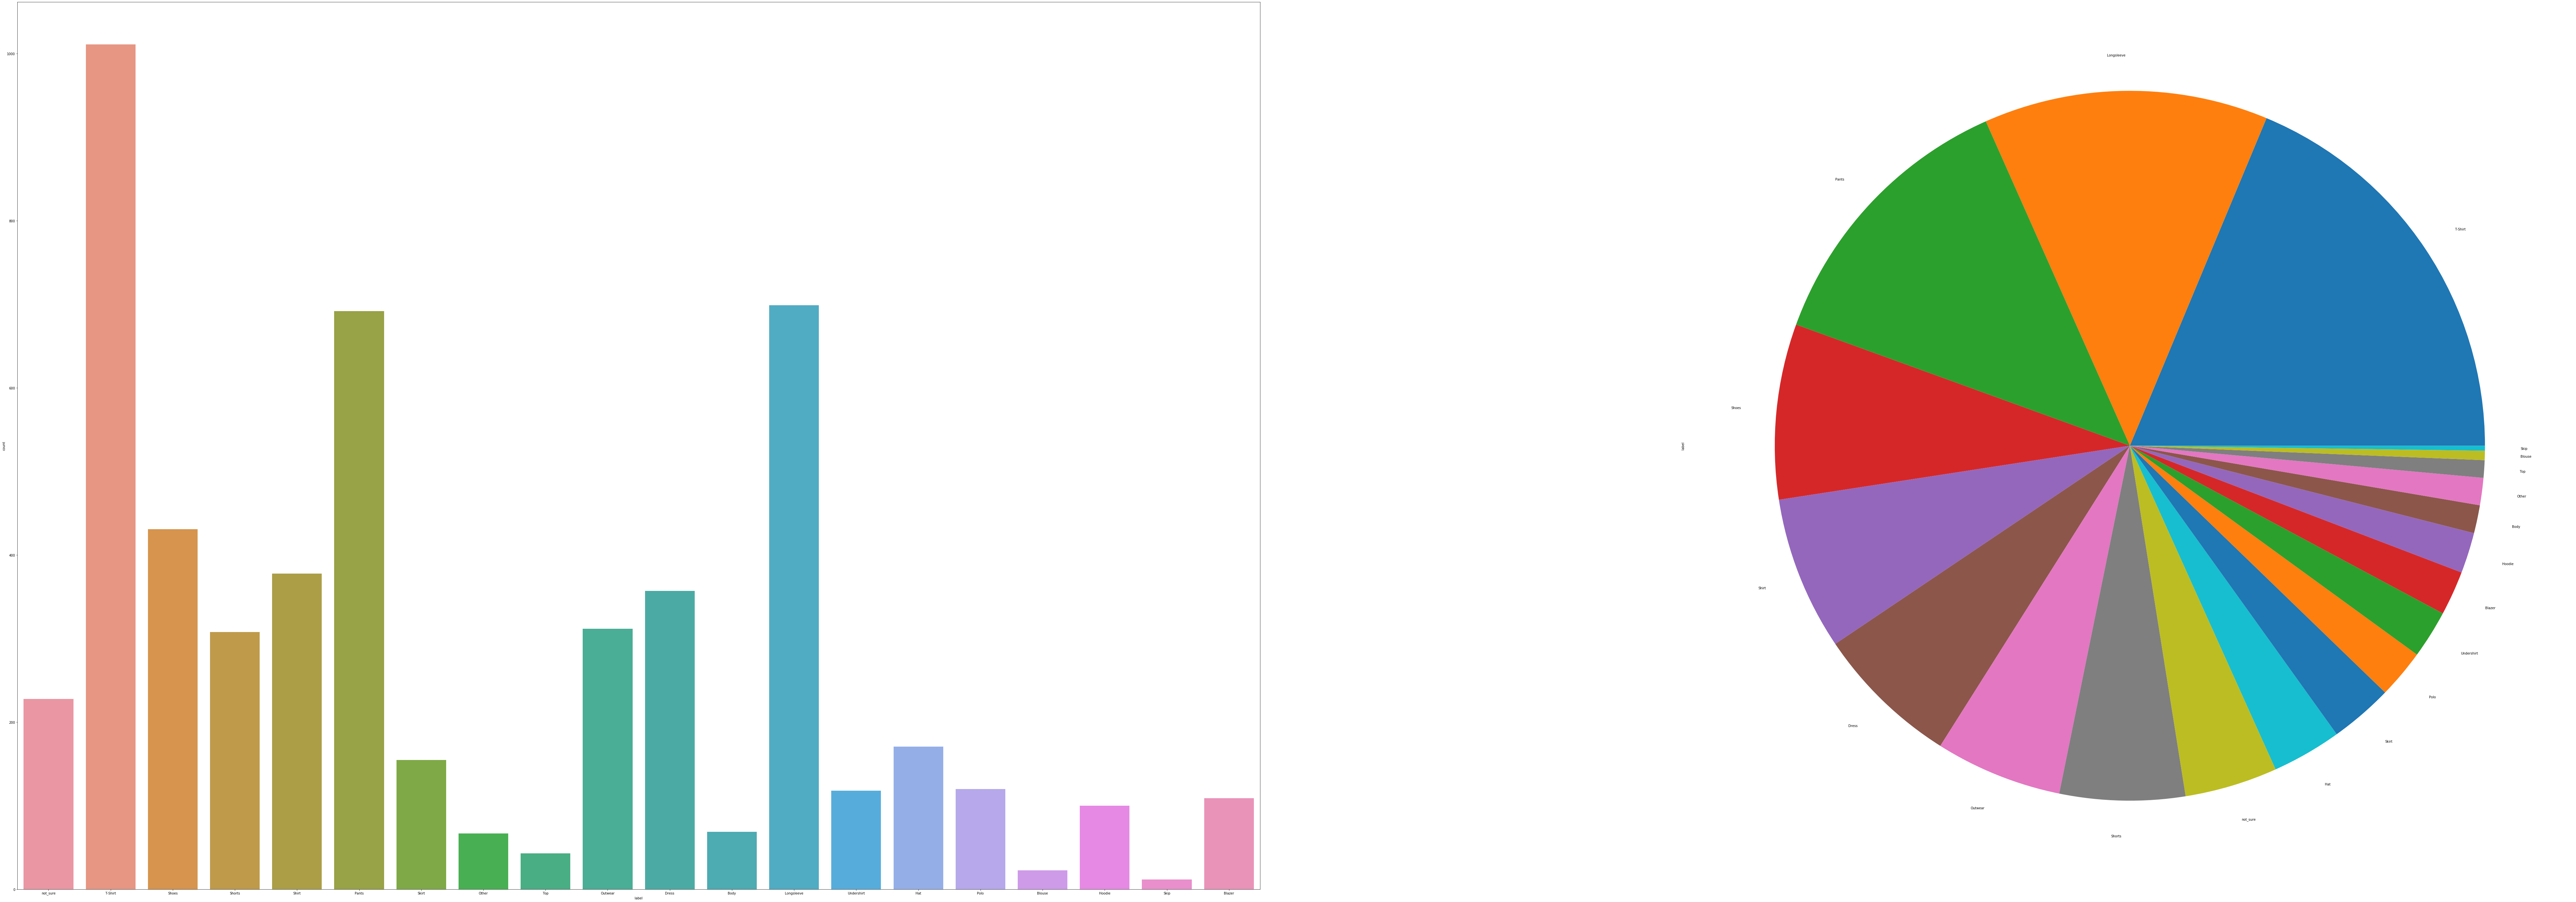

In [36]:
#DATA VISUALIZATION
plt.figure(figsize = (150, 50))
plt.subplot(1, 2, 1)
sns.countplot(x=df['label'])
plt.subplot(1, 2, 2)
df['label'].value_counts().plot.pie(y='Class')

# Data Cleaning

In [12]:
df['image'] = df['image'] + '.jpg'

In [13]:
df['label_cat'] = df['label'] + ' ' + df['kids'].astype(str)

In [14]:
label_df = df[['image', 'label_cat']]
label_df.head()

,image,label_cat
0,4285fab0-751a-4b74-8e9b-43af05deee22.jpg,not_sure False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt False
2,00627a3f-0477-401c-95eb-92642cbe078d.jpg,not_sure False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes False


# Preprocessing

In [15]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [21]:
path=r'C:/Users/Gowtham/Desktop/images_original'
def get_x(r): return path+'/'+r['image'] 
def get_y(r): return r['label_cat'].split(' ')

In [22]:
# Create DataBlock
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                  get_x = get_x, get_y = get_y,
                  item_tfms = RandomResizedCrop(128, min_scale=0.35))  # ensure every item is of the same size
dls = dblock.dataloaders(label_df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


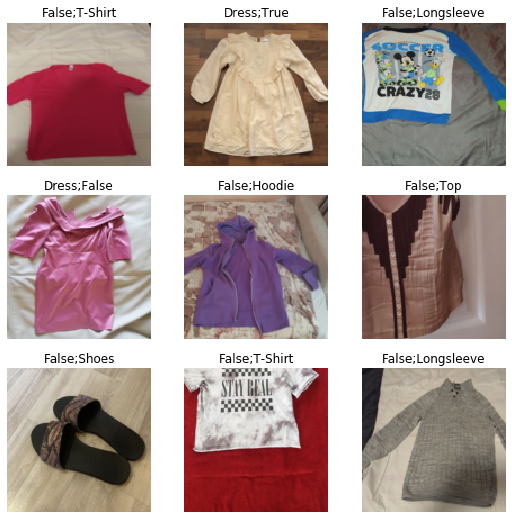

In [23]:
dls.show_batch(nrows=3, ncols=3)

# Creating the learner

In [24]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5, base_lr=3e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Gowtham/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.794184,0.337665,0.502862,1:16:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.315653,0.158081,0.904882,49:08
1,0.189184,0.104834,0.958249,12:01:52
2,0.134092,0.091601,0.963384,49:46
3,0.108284,0.085869,0.963636,50:13
4,0.096696,0.084076,0.964647,50:24


In [38]:
#Using 5 epocs, we trained the last layer of the CNN with 18 layers and used the learning rate of 0.003.
#The 'fine_tune' function uses one epoch to train the final layer on the CNN and then unfreezes the entire model
#and trains all the 18 layers. With 5 epochs, we have been able to gain a training accuracy of 96.48%.

In [26]:
# Get Predictions and target variables
preds,targs = learn.get_preds()

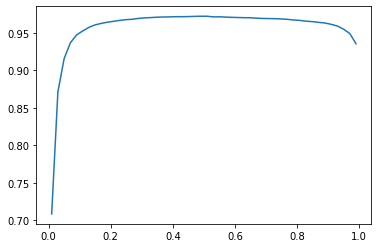

In [27]:
xs = torch.linspace(0.01,0.99,50)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] # get_preds applies sigmoid activation function
plt.plot(xs,accs);

In [37]:
#The predictictions are high at the threshold value of 0.1 and above.
#The smoothness of the curve until what seems to be 0.9 shows that we wont be overfitting by picking a random value.
#Thus maintaining the threshold at 0.2 should result in non-biased predictions.

In [28]:
learn.export(Path("C:/Users/Gowtham/Desktop/export.pkl"))

In [29]:
upload = widgets.FileUpload()
out_image = widgets.Output()
prediction = widgets.Label()
run = widgets.Button(description='Classify')

In [30]:
def on_click_classify(change):
    img = PILImage.create(upload.data[-1])
    out_image.clear_output()
    with out_image: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    pred0 = pred[0]
    pred1 = pred[1]
    if pred0=='False':
        prediction.value = f'This is a {pred1} for adults.'
    else:
        prediction.value = f'This is a {pred1} for kids.'

run.on_click(on_click_classify)


In [31]:
# Use Virtual Box to encapsulate the iPython widgets
VBox([widgets.Label('Upload a picture of a pice of clothing!'), 
      upload, run, out_image, prediction])